In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-Learn for Data Processing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Device Configuration (Use GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


Using device: cuda


In [2]:
import torch
print(f"Torch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")
# Doit afficher True et votre RTX 2000 Ada

Torch: 2.5.1+cu121
CUDA: True


### Data Loading

In [3]:
#  CELL 2: LOAD DATASETS 

# Define file paths
FILE_KOI = "/home/julian/Environnements Python/Exoplanet_Project/DATA/q1_q8_koi_2025.02.03_04.12.15.csv"
FILE_STELLAR = "/home/julian/Environnements Python/Exoplanet_Project/DATA/keplerstellar_2025.02.03_04.41.47.csv"
FILE_FPP = "/home/julian/Environnements Python/Exoplanet_Project/DATA/q1_q17_dr25_koifpp_2025.02.03_06.14.34.csv"

try:
    # Load data with comment='#' to ignore metadata headers
    # We also specify index_col=False to force Pandas not to use the first column as an index
    df_koi = pd.read_csv(FILE_KOI, comment='#')
    df_stellar = pd.read_csv(FILE_STELLAR, comment='#')
    df_fpp = pd.read_csv(FILE_FPP, comment='#')
    
    print("Datasets loaded successfully.")
    print(f"KOI Shape: {df_koi.shape}")
    print(f"Stellar Shape: {df_stellar.shape}")
    print(f"FPP Shape: {df_fpp.shape}")

except Exception as e:
    print(f"Error loading files: {e}")

Datasets loaded successfully.
KOI Shape: (3865, 49)
Stellar Shape: (990244, 33)
FPP Shape: (8054, 35)


In [4]:
# DATA MERGING & ENGINEERING 

# 1. Merge KOI and Stellar Data
# We want to attach star properties to each planet candidate.
# We select only useful columns from the stellar file to avoid duplicates.
cols_stellar = ['kepid', 'teff', 'logg', 'radius', 'feh'] # ID, Temp, Gravity, Radius, Metallicity

# Check for the common column 'kepid'
if 'kepid' in df_koi.columns and 'kepid' in df_stellar.columns:
    df_merged = pd.merge(df_koi, df_stellar[cols_stellar], on='kepid', how='inner')
    print(f" Merge successful. Combined shape: {df_merged.shape}")
else:
    raise ValueError("Column 'kepid' not found for merging.")

# 2. Define Target Label (y)
# We filter only relevant rows
valid_dispositions = ['CONFIRMED', 'CANDIDATE', 'FALSE POSITIVE']
df_merged = df_merged[df_merged['koi_disposition'].isin(valid_dispositions)]

# Binarize: 1 = Planet (Confirmed/Candidate), 0 = False Positive
df_merged['target'] = df_merged['koi_disposition'].apply(
    lambda x: 0 if x == 'FALSE POSITIVE' else 1
)

# 3. Select Features (X)
# We choose physical parameters relevant for detection
features_list = [
    'koi_period',      # Orbital Period (days)
    'koi_time0bk',     # Transit Epoch
    'koi_duration',    # Duration (hours)
    'koi_depth',       # Transit Depth (ppm)
    'koi_prad',        # Planetary Radius (Earth radii)
    'koi_teq',         # Equilibrium Temperature (Kelvin)
    'koi_insol',       # Insolation Flux
    'teff',            # Stellar Effective Temperature
    'logg',            # Stellar Surface Gravity
    'radius'           # Stellar Radius
]

X = df_merged[features_list]
y = df_merged['target']

print(f" Data ready. X shape: {X.shape}, y shape: {y.shape}")
print(f"   - Class Balance: {y.value_counts().to_dict()}")

 Merge successful. Combined shape: (19309, 53)
 Data ready. X shape: (16419, 10), y shape: (16419,)
   - Class Balance: {1: 12923, 0: 3496}


In [5]:
#  CELL 4: PREPROCESSING (IMPUTATION & SCALING) 

# 1. Handle Missing Values (Imputation)
# Neural networks cannot handle NaNs. We fill them with the median.
print("Filling missing values...")
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# 2. Split Data (Train / Validation / Test)
# 80% Train, 10% Val, 10% Test
X_train_raw, X_temp, y_train, y_temp = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)
X_val_raw, X_test_raw, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

# 3. Normalization (StandardScaler)
# Critical for Deep Learning convergence.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_raw)
X_val_scaled = scaler.transform(X_val_raw)
X_test_scaled = scaler.transform(X_test_raw)

print(" Preprocessing complete.")
print(f"   - Train set: {X_train_scaled.shape}")
print(f"   - Test set: {X_test_scaled.shape}")
print(f"   - Val set: {X_val_scaled.shape}")

Filling missing values...
 Preprocessing complete.
   - Train set: (13135, 9)
   - Test set: (1642, 9)
   - Val set: (1642, 9)


In [6]:
# PYTORCH DATASET & LOADERS 

class ExoplanetDataset(Dataset):
    def __init__(self, features, labels):
        # Convert to PyTorch tensors (Float32)
        self.features = torch.tensor(features, dtype=torch.float32)
        # Reshape labels to [batch_size, 1]
        self.labels = torch.tensor(labels.values, dtype=torch.float32).unsqueeze(1)
        
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create Dataset Objects
train_dataset = ExoplanetDataset(X_train_scaled, y_train)
val_dataset = ExoplanetDataset(X_val_scaled, y_val)
test_dataset = ExoplanetDataset(X_test_scaled, y_test)

# Create DataLoaders (Batching)
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print("DataLoaders created.")

DataLoaders created.


In [7]:
# Model

class ExoNet(nn.Module):
    def __init__(self, input_dim):
        super(ExoNet, self).__init__()
        
        # Layer 1: Input -> 64 neurons
        self.layer1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)   # Stabilizes training
        self.relu = nn.ReLU()           # Activation function
        self.dropout = nn.Dropout(0.3)  # Prevents overfitting
        
        # Layer 2: 64 -> 32 neurons
        self.layer2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        
        # Output Layer: 32 -> 1 neuron (Binary classification)
        self.output = nn.Linear(32, 1) 
        
    def forward(self, x):
        x = self.dropout(self.relu(self.bn1(self.layer1(x))))
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.output(x)
        return x

# Initialize Model
input_dim = X_train_scaled.shape[1]
model = ExoNet(input_dim).to(device)

print(" Model initialized:")
print(model)

 Model initialized:
ExoNet(
  (layer1): Linear(in_features=9, out_features=64, bias=True)
  (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
  (layer2): Linear(in_features=64, out_features=32, bias=True)
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=32, out_features=1, bias=True)
)


 Starting training...
Epoch 10/100 | Train Loss: 0.3876 | Val Loss: 0.3881
Epoch 20/100 | Train Loss: 0.3791 | Val Loss: 0.3823
Epoch 30/100 | Train Loss: 0.3717 | Val Loss: 0.3663
Epoch 40/100 | Train Loss: 0.3674 | Val Loss: 0.3560
Epoch 50/100 | Train Loss: 0.3595 | Val Loss: 0.3591
Epoch 60/100 | Train Loss: 0.3570 | Val Loss: 0.3495
Epoch 70/100 | Train Loss: 0.3545 | Val Loss: 0.3471
Epoch 80/100 | Train Loss: 0.3492 | Val Loss: 0.3470
Epoch 90/100 | Train Loss: 0.3490 | Val Loss: 0.3463
Epoch 100/100 | Train Loss: 0.3429 | Val Loss: 0.3418
 Training complete.


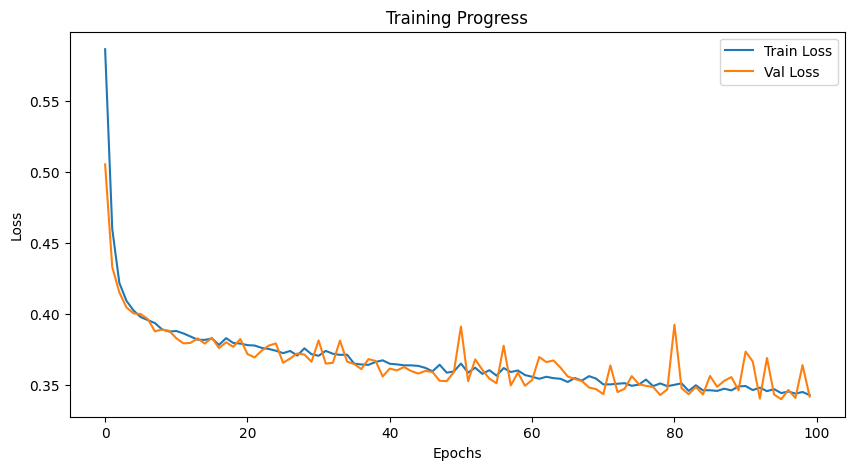

In [8]:
# TRAINING LOOP 

# Hyperparameters
EPOCHS = 100
LEARNING_RATE = 3e-4

# Loss and Optimizer
criterion = nn.BCEWithLogitsLoss() # For binary classification
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# History tracking
history = {'train_loss': [], 'val_loss': []}

print(" Starting training...")

for epoch in range(EPOCHS):
    model.train()
    train_loss = 0
    
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        # Forward
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()
    
    # Calculate average loss
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

print(" Training complete.")

# Plot Learning Curve
plt.figure(figsize=(10, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Training Progress')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluating on Test Set...

 CLASSIFICATION REPORT 
                precision    recall  f1-score   support

False Positive       0.81      0.45      0.58       350
        Planet       0.87      0.97      0.92      1292

      accuracy                           0.86      1642
     macro avg       0.84      0.71      0.75      1642
  weighted avg       0.85      0.86      0.84      1642



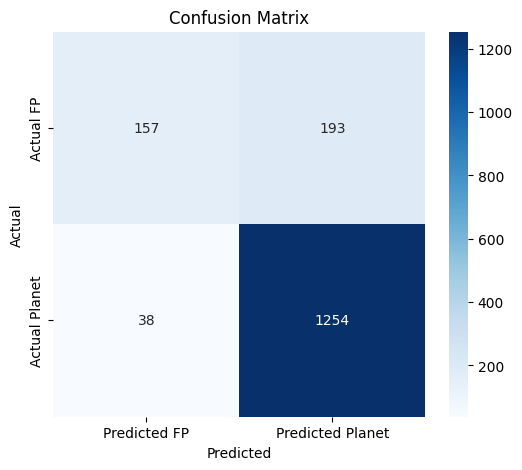

In [9]:
# EVALUATION 

model.eval()
y_true = []
y_pred = []

print("Evaluating on Test Set...")

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        
        # Get predictions
        logits = model(X_batch)
        probs = torch.sigmoid(logits)      # Convert to probability (0 to 1)
        preds = torch.round(probs)         # Convert to class (0 or 1)
        
        # Store results
        y_true.extend(y_batch.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Display Metrics
print("\n CLASSIFICATION REPORT ")
print(classification_report(y_true, y_pred, target_names=['False Positive', 'Planet']))

# Display Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted FP', 'Predicted Planet'], yticklabels=['Actual FP', 'Actual Planet'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()